In [1]:
import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdate

In [2]:
from matplotlib.font_manager import _rebuild
_rebuild()

In [3]:
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['simhei']

In [4]:
class FundData():
    date = []    #日期
    dwjz = []    #当日单位净值
    jjrzzl = []  #基金日增长率
    name = ""    #基金名称
    code = ""    #基金代码

In [6]:
fund_code_df = pd.read_csv('./data/fundcode.csv',header=0)
buy_fund = [line.split('/') for line in open('FundBuyRecord.txt')]
buy_fund_dict = {}
for bf in buy_fund:
    if bf[0] not in buy_fund_dict:
        buy_fund_dict[bf[0]] = [bf[1:]]
    else:
        buy_fund_dict[bf[0]].append(bf[1:])

In [9]:
def load_fund_data(fund_code, start_date=None, end_date=None):
    fdata = FundData()
    if not end_date:
        end_date = datetime.date.today()
    else:
        end_date = datetime.datetime.strptime(end_date,'%Y-%m-%d').date()
    if not start_date:
        start_date = (datetime.date.today() - relativedelta(months=+1))
    else:
        start_date = datetime.datetime.strptime(start_date,'%Y-%m-%d').date()
        
    data = pd.read_csv('./data/%s_lsjz.csv' % str(fund_code),header=0)
    data.drop_duplicates(keep='first',inplace=True)
    data['FSRQ'] = data['FSRQ'].map(lambda x : datetime.datetime.strptime(x,'%Y-%m-%d').date())
    #data['FSRQ']=data['FSRQ'].astype('datetime64[ns]') 
    
    data.sort_values(by='FSRQ',ascending=True, inplace =True)
    data.fillna(0,inplace=True)
    data = data.loc[((data['FSRQ']>=start_date) & (data['FSRQ']<=end_date)),:]
    data.loc[data['FSRQ'] == start_date,'JZZZL'] = 0
    data.loc[:,'JZZZL'] = data.loc[:,'JZZZL'].values.cumsum()
    
    fdata.date = [d.strftime("%Y-%m-%d") for d in data['FSRQ'].values]
    fdata.jjrzzl = data['JZZZL'].values
    fdata.dwjz = data['DWJZ'].values
    fdata.name = str(fund_code) + fund_code_df.loc[fund_code_df['fundcode'] == int(fund_code),'name'].values[0]
    fdata.code = fund_code
    
    return fdata
    

In [23]:
def draw_fund_trend(fund_data_list):
    start_date = fund_data_list[0].date[0]
    end_date = fund_data_list[0].date[-1]
    
    fig = plt.figure(figsize=(16,9))
    ax = fig.add_subplot(111)
    
    for fund_data in fund_data_list:
        plt.plot(fund_data.date, fund_data.jjrzzl, label=fund_data.name, linestyle='-', linewidth=2)
        
        for date, amount in buy_fund_dict[fund_data.code]:
            amount = float(amount)
            fc = 'red' if amount > 0 else 'green'
            label='BuyRecord'
            if fc == 'green':
                amount = -1* amount
                label='SellRecord'
            try:
                x = fund_data.date.index(date)
                y = fund_data.jjrzzl[x]
                plt.scatter([x], [y], s=np.pi*3**2, c=fc, alpha=0.8)
            except:
                pass

    plt.ylabel('基金累计涨幅 (%)',fontproperties="SimHei",fontsize=15)
    ax.axes.set_xticklabels(fund_data_list[0].date,rotation=90)

    plt.legend(prop= {'family' : 'SimHei','weight' : 'normal', 'size' : 12})
    plt.title("基金业绩走势",fontproperties="SimHei",fontsize=18)
    plt.show(block=True)
    plt.close()


In [34]:
def draw_sigleFund_trend_with_buyRecord(fund_data):
    fig = plt.figure(figsize=(16,6))
    ax = fig.add_subplot(111)
    
    plt.plot(fund_data.date, fund_data.jjrzzl, label="基金涨幅趋势", linestyle='-', linewidth=2)
    for date, amount in buy_fund_dict[fund_data.code]:
        amount = float(amount)
        fc = 'red' if amount > 0 else 'green'
        label='BuyRecord'
        if fc == 'green':
            amount = -1* amount
            label='SellRecord'
        
        try:
            x = fund_data.date.index(date)
            y = fund_data.jjrzzl[x]

            plt.annotate(s=str(amount),xy=(x-0.1,y+0.1),xytext=(x-0.1,y+0.5),weight='bold',color='white',\
                         arrowprops=dict(arrowstyle='-|>',connectionstyle='arc3',color=fc),\
                         bbox=dict(boxstyle='square,pad=0.3', fc=fc,ec=fc,lw=1 ,alpha=0.8))
            plt.scatter([x], [y], s=np.pi*3**2, c=fc, alpha=0.8)
        except:
            pass
    
    plt.ylabel('基金累计涨幅 (%)',fontproperties="SimHei",fontsize=15)
    ax.axes.set_xticklabels(fund_data.date,rotation=90)
    plt.legend(prop= {'family' : 'SimHei','weight' : 'normal', 'size' : 12})
    plt.title(fund_data.name, fontproperties="SimHei",fontsize=18)
    plt.show(block=True)
    plt.close()

In [14]:
# def draw_sigleFund_trend_with_buyPoint(fund_data):
#     figure, ax1 = plt.subplots(figsize=(16,6))
#     ax2 = ax1.twinx()
#     ax1.plot(fund_data.date, fund_data.jjrzzl, label='基金累计涨幅', linestyle='--', linewidth=2,color='green')
#     ax2.plot(fund_data.date, fund_data.dwjz, label='基金单位净值', linestyle='-', linewidth=2,color='blue')
#     ax1.set_ylabel("基金累计涨幅(%)",fontdict =  {'family':'SimHei', 'weight':'normal', 'size':15})
#     ax2.set_ylabel("基金单位净值(元)", fontdict =  {'family':'SimHei', 'weight':'normal', 'size':15})
#     ax1.axes.set_xticklabels(fund_data.date,rotation=90)

#     plt.legend(prop= {'family' : 'SimHei','weight' : 'normal', 'size' : 12})
#     plt.title(fund_data.name, fontproperties="SimHei",fontsize=18)
#     plt.show(block=True)
#     plt.close()

In [35]:
data_list = []
for fund_code in buy_fund_dict.keys():
    try:
        data = load_fund_data(fund_code,start_date='2020-01-09')
        if data:
            data_list.append(data)
    except FileNotFoundError:
        print(fund_code)

008133


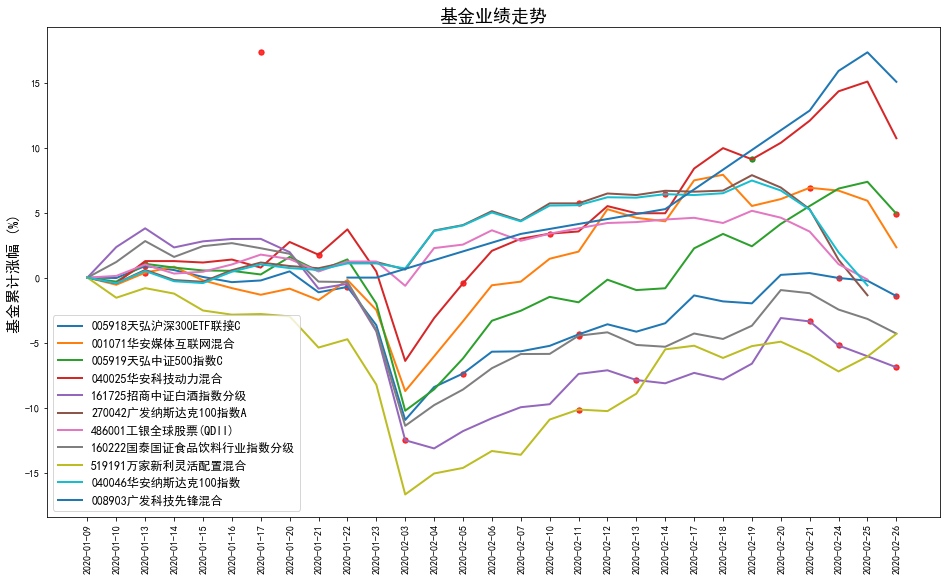

In [36]:
draw_fund_trend(data_list)

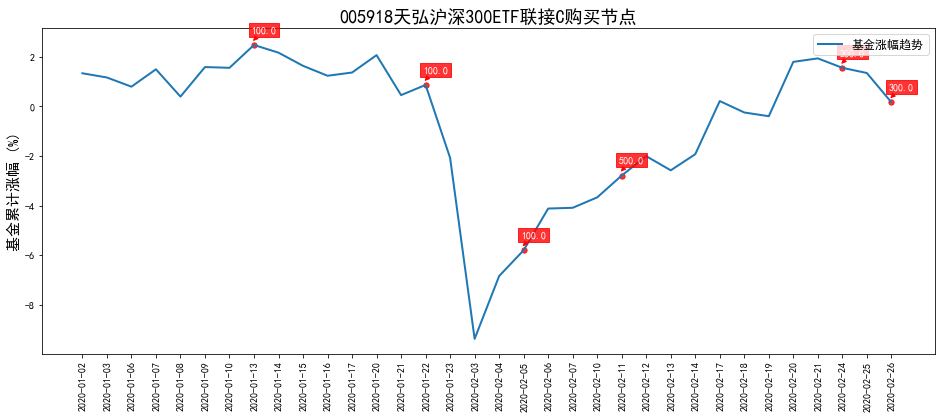

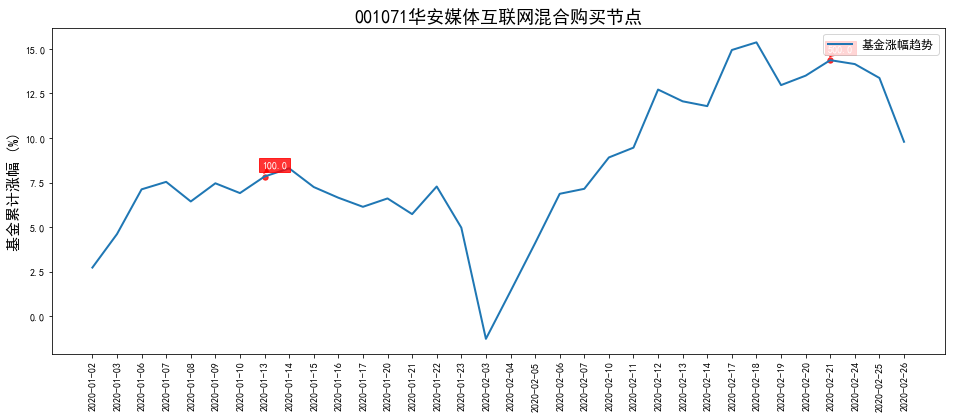

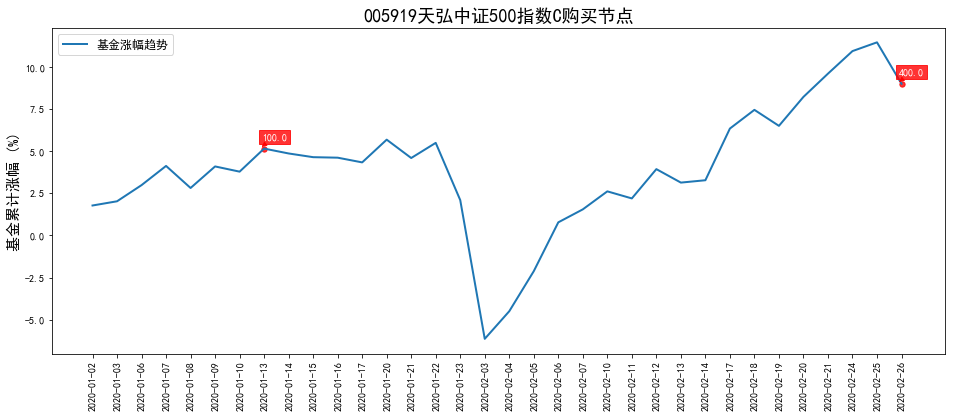

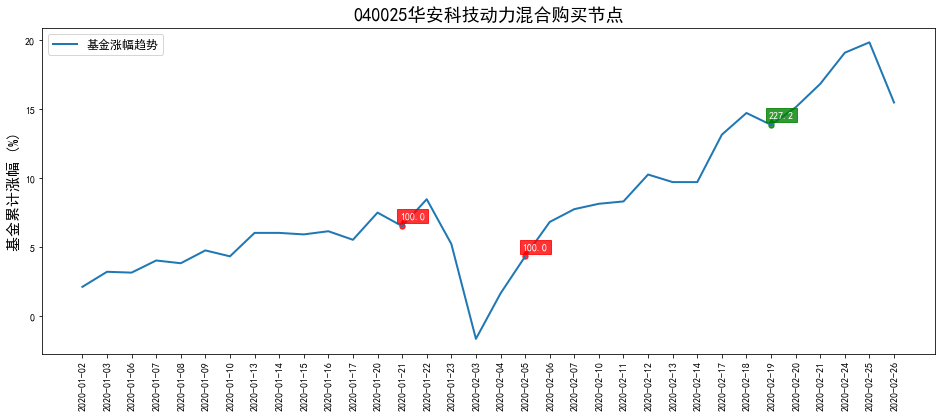

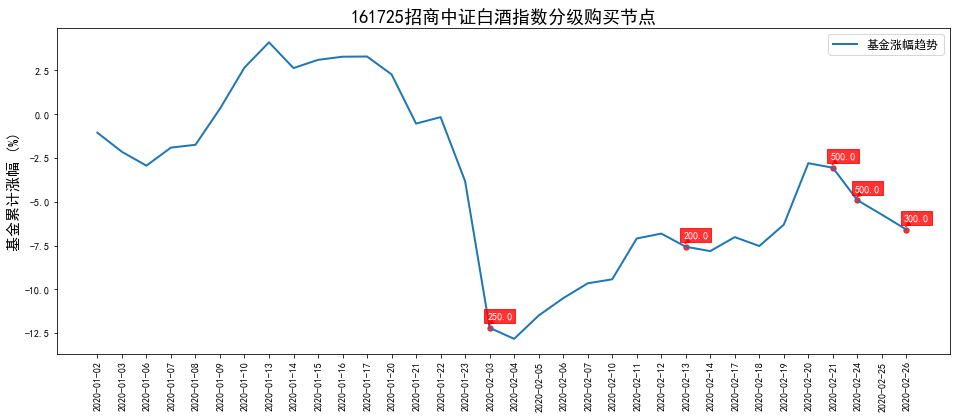

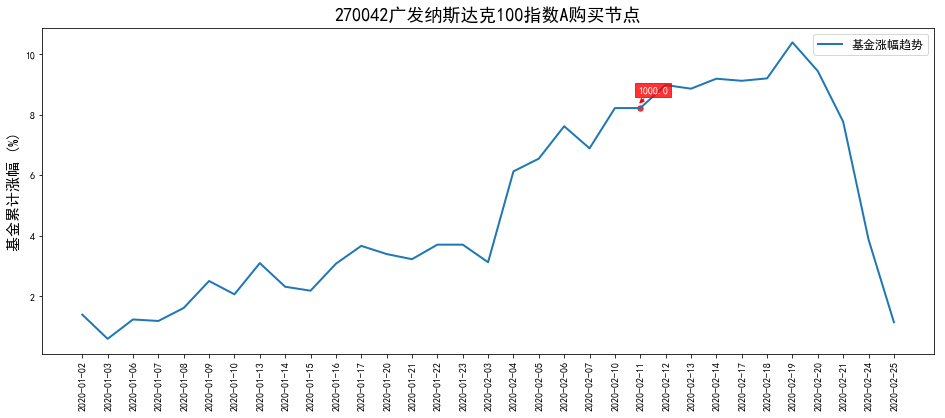

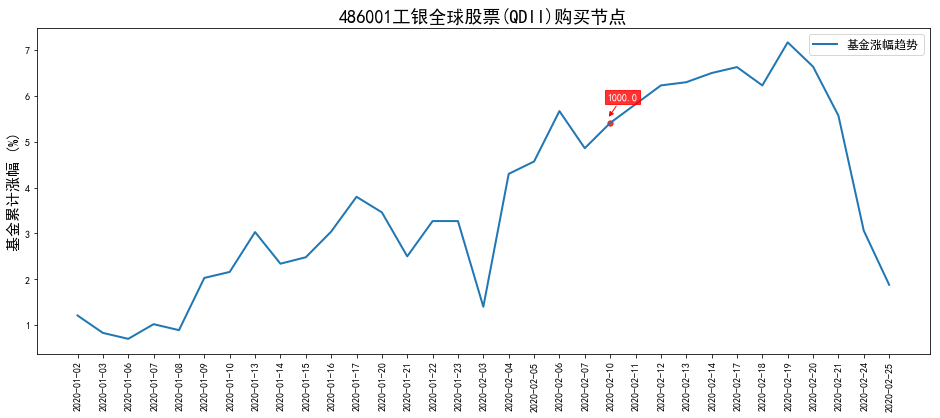

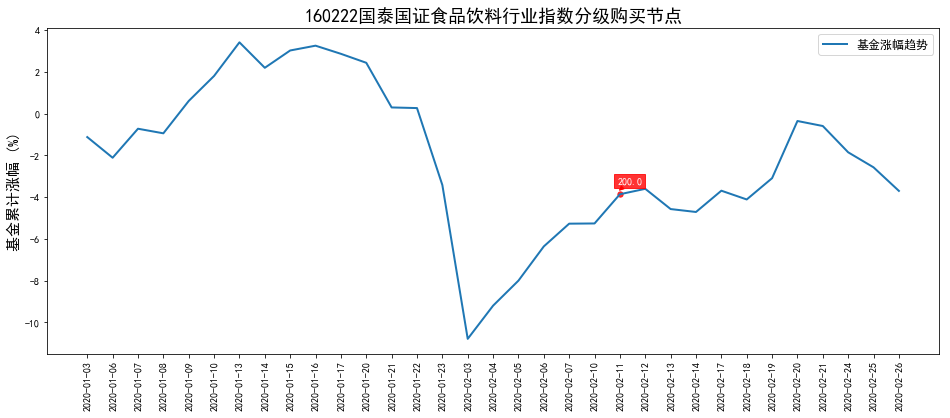

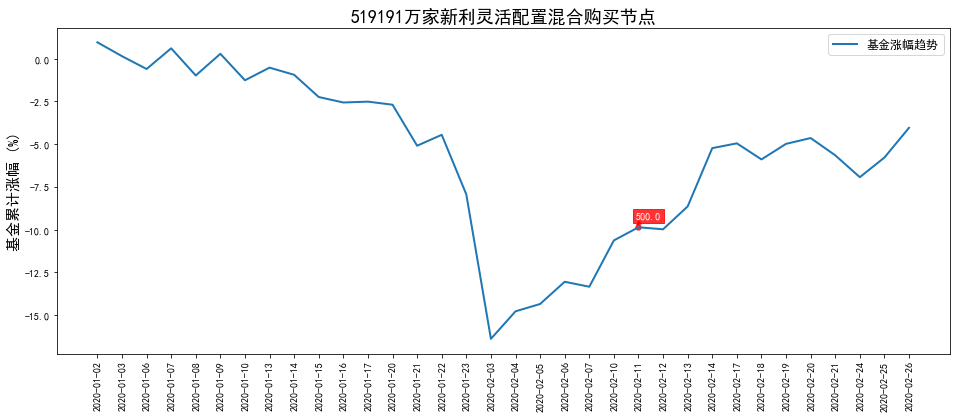

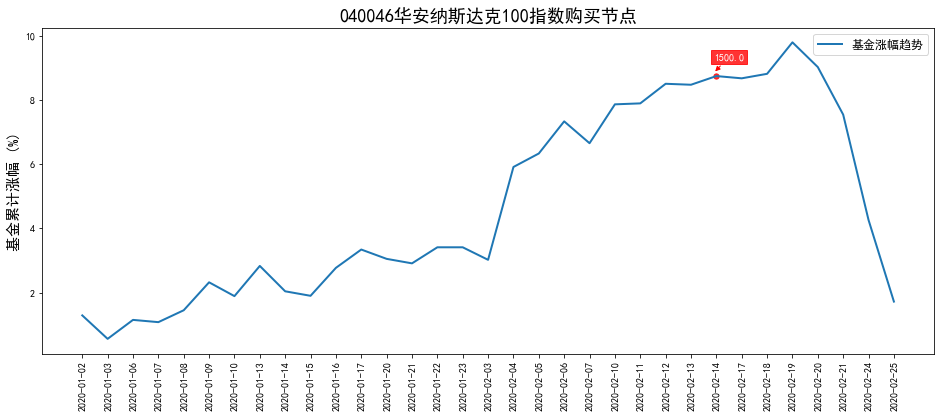

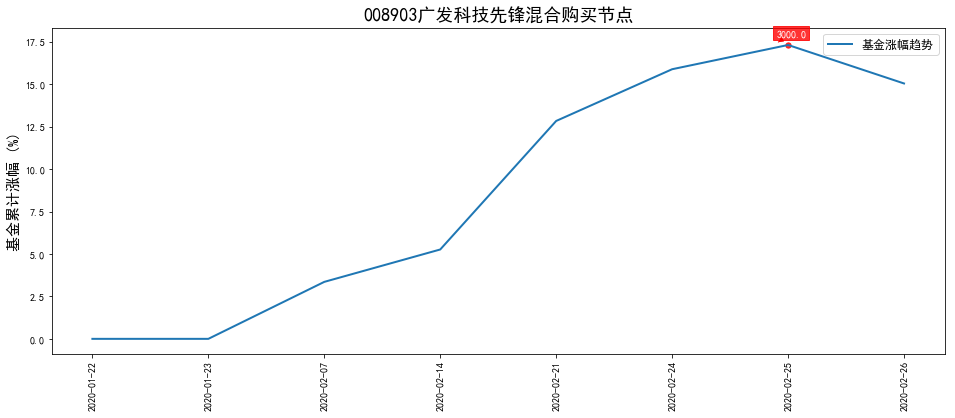

In [33]:
for data in data_list:
    draw_sigleFund_trend_with_buyRecord(data)